# Railway Delay Analysis - Tübingen (Germany)
---



## 1. Introduction

### 1.1. Project Motivation

Reliable public transportation plays a crucial role in urban mobility in Germany, especially for commuters and students who depend on the railway system on a daily basis.

This project analyzes the punctuality and reliability of the German railway system (Deutsche Bahn) at Tübingen Hauptbahnhof (Hbf), using one full year of operational data. The primary objective is to identify recurring patterns in train delays and assess their impact on passengers over time.

The motivation for this analysis comes from personal observation and lived experience in the Baden-Württemberg region, where frequent delays are commonly reported by daily train users. While these issues are often discussed informally among commuters, this project aims to move beyond perception and provide a data-driven assessment of the system’s performance.

By combining exploratory data analysis, statistical hypothesis testing, and predictive modeling, this study evaluates how the railway system behaves under different operational conditions, such as peak hours, seasonal changes, and infrastructure constraints.


### 1.2. Project Scope & Methodological Overview

This project follows a structured end-to-end data science workflow, designed to translate passenger experiences into measurable and actionable insights:

•  **Data collection and cleaning**: Extraction and filtering of one year of high-volume railway operation data for Tübingen Hbf.

•  **Exploratory Data Analysis (EDA)**: Identification of temporal, spatial, and operational delay patterns.

•  **Statistical hypothesis testing**: Validation of commonly reported commuter perceptions, such as weekday effects and service-type differences.

•  **Feature engineering**: Construction of temporal, categorical, and operational features, including peak-hour indicators and service classifications.

•  **Predictive modeling**: Application of both regression models (to estimate delay duration) and classification models (to predict the risk of critical delays).

•  **Evaluation and interpretation**: Assessment of model performance alongside an explicit discussion of real-world limitations and uncertainty.


## 2. Business Problem
From an operational and economic perspective, train delays represent a significant challenge for public transportation systems, affecting both productivity and passenger quality of life. For a transport provider such as Deutsche Bahn, understanding the operational drivers behind delays is essential for improving planning, resource allocation, and communication with passengers.

The region of Baden-Württemberg, which is the focus of this analysis, operates within a highly interconnected rail network and is currently undergoing major infrastructure changes, most notably the Stuttgart 21 project. In such a complex system, even small disruptions can propagate and impact overall network stability.

Within this context, this project addresses the following business-oriented questions:

* **Predictability**: Can train delays be predicted using operational features such as train category (regional vs. long-distance), departure time, and destination?

* **Reliability**: Which routes or destinations consistently present a higher delay risk for passengers?

* **Network Effect**: How do stochastic events (random disruptions) and cascading delays (delays caused by earlier delayed trains) limit the ability to accurately predict arrival and departure times?


* **Temporal Stability**: How does punctuality vary across different periods of the year?

* **Seasonality**: Do seasonal factors such as winter conditions, summer maintenance works (Baustellen), and holiday travel periods influence network stability?


* **Geographical Bottlenecks**: Are certain directions or regions (e.g., North vs. South) more affected by delays, and how does this compare with public perceptions surrounding large infrastructure projects like Stuttgart 21?

Rather than assuming perfect predictability, this project also investigates the structural limits of delay prediction in a complex railway network.


## 3. Data Overview & Preparation
### 3.1. Data Source & Engineering Strategy
The dataset used in this project is derived from the **Deutsche Bahn Railway Data**, accessed via a large-scale public repository hosted on Hugging Face ([piebro/deutsche-bahn-data](https://https://https//huggingface.co/datasets/piebro/deutsche-bahn-data)).

As the original dataset contains millions of records covering train operations across Germany, a direct full download would be inefficient and unnecessary for a regional analysis. To address this, a **Python streaming approach** was applied, allowing incremental processing and selective extraction.

Using this strategy, all records related to Tübingen Hbf over a continuous 12-month period (August 2024 to July 2025) were extracted and consolidated into a local master dataset, which serves as the basis for the exploratory analysis and modeling stages.


### 3.2. Import Libraries
The following Python libraries are used throughout the analysis.


In [ ]:
# Data manipulation & visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
%matplotlib inline
import matplotlib.dates as mdates

# Statistical analysis
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose

# Machine learning
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, r2_score, classification_report, confusion_matrix, accuracy_score

# Geospatial visualization
import folium
from folium import Map, Figure, Marker, Icon, CircleMarker, PolyLine


### 3.3. Dataset Loading & Initial Preview
The CSV file generated through the streaming process is loaded at this stage. An initial inspection is used to confirm that the dataset structure and size match expectations.

In [ ]:
# Load the dataset
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/Colab Notebooks/Deutsche Bahn Delay/Data/master_dataset_tubingen.csv'
df = pd.read_csv(file_path)

# Initial inspection
print(f"Dataset Shape: {df.shape}")
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset Shape: (25383, 16)


,station_name,xml_station_name,eva,train_name,final_destination_station,delay_in_min,time,is_canceled,train_type,train_line_ride_id,train_line_station_num,arrival_planned_time,arrival_change_time,departure_planned_time,departure_change_time,id
0,Tübingen Hbf,Tübingen Hbf,8000141,RB 74,Tübingen Hbf,4,2024-08-01 08:05:00,False,RB,NaN,8,2024-08-01 08:01:00,2024-08-01 08:05:00,NaN,NaN,-2297100159431365610-2408010725-8
1,Tübingen Hbf,Tübingen Hbf,8000141,RB 6,Rottenburg(Neckar),0,2024-08-01 08:06:00,False,RB,NaN,1,NaN,NaN,2024-08-01 08:06:00,2024-08-01 08:06:00,-8405446999753013706-2408010806-1
2,Tübingen Hbf,Tübingen Hbf,8000141,RB 63,Tübingen Hbf,0,2024-08-01 08:13:00,False,RB,NaN,8,2024-08-01 08:13:00,2024-08-01 08:13:00,NaN,NaN,-1894659457855522388-2408010748-8
3,Tübingen Hbf,Tübingen Hbf,8000141,RB 63,Herrenberg,0,2024-08-01 08:17:00,False,RB,4.682770e+18,1,NaN,NaN,2024-08-01 08:17:00,2024-08-01 08:17:00,4682769519521374202-2408010817-1
4,Tübingen Hbf,Tübingen Hbf,8000141,SWE RB66,Tübingen Hbf,3,2024-08-01 08:31:00,False,SWE,NaN,17,2024-08-01 08:28:00,2024-08-01 08:31:00,NaN,NaN,-7569594639293726781-2408010709-17


### 3.4. Data Cleaning & Basic Filtering
To ensure that the exploratory analysis reflects operational reality, at this stage only a small set of basic data cleaning steps is applied:

* The `time` column is converted to a datetime format to enable temporal grouping and trend analysis in subsequent sections.

* Negative delay values are removed. These values usually indicate early arrivals or technical timestamp adjustments and do not represent actual operational delays experienced by passengers. Trains whose final destination is Tübingen Hbf are intentionally retained. As Tübingen Hbf functions both as an origin and terminal station, excluding these records would artificially reduce average delay estimates and distort the interpretation of punctuality.

In [ ]:
# Converting ‘time’ column format for temporal analysis
df['time'] = pd.to_datetime(df['time'])

# Removing invalid negative delays
df = df[df['delay_in_min'] >= 0].copy()

print(f" Records retained for analysis: {len(df)}")
print(f" Average delay after basic cleaning: {df['delay_in_min'].mean():.2f} minutes")

 Records retained for analysis: 24760
 Average delay after basic cleaning: 3.23 minutes


This approach ensures that the analysis remains aligned with how delays are actually experienced by passengers.

## 4. Data Exploration & Insights

This section presents an exploratory analysis of train delays at Tübingen Hbf, focusing on delay magnitude, temporal patterns, and service reliability.
The objective is not model optimization, but to capture how delays are experienced in real-world operations, establishing a realistic baseline for subsequent analysis.

### 4.1. General Performance Statistics
We start by examining overall performance indicators. These statistics provide initial context for system reliability and passenger experience.

In [ ]:
# Overall stats
print(df[['delay_in_min']].describe())

       delay_in_min
count  24760.000000
mean       3.228756
std        6.893436
min        0.000000
25%        0.000000
50%        1.000000
75%        4.000000
max      331.000000


The distribution highlights a moderate average delay with 75% of services delayed by up to 4 minutes but with high variability and extreme outliers (maximum delay = 331 minutes), indicating that punctuality issues are not evenly distributed across services.

To better reflect passenger experience, we examine the share of punctual versus delayed trains:

In [ ]:
# Mean of punctual versus mean of delayed trains
on_time_rate = (df['delay_in_min'] == 0).mean() * 100
delayed_rate = (df['delay_in_min'] > 0).mean() * 100

print(f"On-time services (0 min delay): {on_time_rate:.1f}%")
print(f"Delayed services (>0 min): {delayed_rate:.1f}%")

On-time services (0 min delay): 32.4%
Delayed services (>0 min): 67.6%


While the mean delay appears relatively low, a clear majority of services (67.6%) experience at least some delay. This contrast between average performance metrics and everyday experience helps explain why passengers often perceive the system as unreliable.

Finally, we explore temporal patterns by day of the week to assess whether commonly reported issues, such as a potential “Monday Effect,” are observable in the data:


In [ ]:
# Average Delay by Day of the Week
df['day_name'] = df['time'].dt.day_name()
weekly_perf = df.groupby('day_name')['delay_in_min'].mean().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])
print(weekly_perf)

day_name
Monday       3.585341
Tuesday      3.381180
Wednesday    3.144957
Thursday     3.092129
Friday       2.936598
Name: delay_in_min, dtype: float64


Mondays consistently exhibit the highest average delays (3.58 minutes) and gradually decrease during the week. Although purely descriptive at this stage, this pattern suggests that early-week operations may be structurally more vulnerable.

### 4.2. Distribution of Delays

As suggested by the summary statistics, most delays are concentrated within the first few minutes. To better understand the typical severity of delays, we visualize the distribution of train delays (`delay_in_min`).

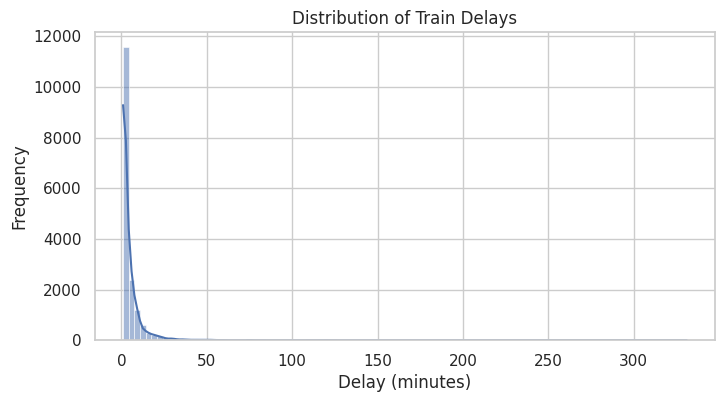

In [ ]:
plt.figure(figsize=(8, 4))
sns.histplot(df[df['delay_in_min'] > 0]['delay_in_min'], bins=100, kde=True)
plt.title('Distribution of Train Delays')
plt.xlabel('Delay (minutes)')
plt.ylabel('Frequency')
plt.show()

The distribution is strongly right-skewed: most delays are concentrated in the first few minutes, as suggested by the summary statistics, while frequency declines sharply beyond approximately 30–35 minutes.

The visual pattern of a long tail suggests that while most delays are short, a small number of severe disruptions dominate the extreme end of the distribution.

To contextualize extreme delay events, we quantify the share of services delayed by more than 30 minutes:


In [ ]:
delayed_df = df[df['delay_in_min'] > 0]
severe_rate = (delayed_df['delay_in_min'] > 30).mean() * 100
print(f"Severe delays (> 30 minutes): {severe_rate:.2f}% of delayed services")

Severe delays (> 30 minutes): 1.24% of delayed services


Although delays exceeding 30 minutes represent only a small fraction of all delayed trains (1.24%), they correspond to a qualitatively different level of disruption. These rare but severe events contribute disproportionately to passenger dissatisfaction and perceived unreliability.

###4.3. Cancellation Analysis: The Critical Failures
Cancellations represent the most severe form of service failure within the rail system. Unlike delays, which may still allow partial recovery, cancellations fully disrupt planned operations and have an immediate impact on passenger experience.

Before examining temporal patterns, we establish the overall scale of cancellations in the dataset:

In [ ]:
print(f"Total Canceled Trains: {df['is_canceled'].sum()}")
print(f"Overall Cancellation Rate: {df['is_canceled'].mean() * 100:.2f}%")

Total Canceled Trains: 722
Overall Cancellation Rate: 2.92%


Despite representing a relatively small share of all services, cancellations signal moments in which the system fails to absorb operational disruptions.

To investigate whether these failures are evenly distributed over time, we analyze cancellations by day of the week:

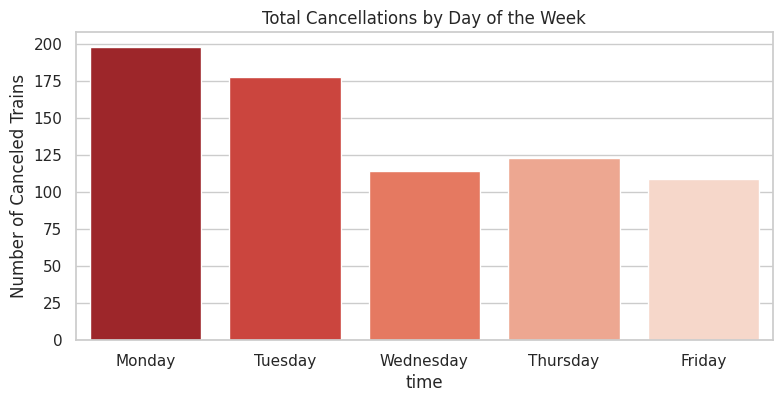

In [ ]:
canceled_df = df[df['is_canceled'] == True].copy()
cancellation_by_day = (canceled_df['time'].dt.day_name().value_counts().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']))

plt.figure(figsize=(9, 4))
sns.barplot(x=cancellation_by_day.index, y=cancellation_by_day.values, hue=cancellation_by_day.index,palette='Reds_r', legend=False)
plt.title('Total Cancellations by Day of the Week')
plt.ylabel('Number of Canceled Trains')
plt.show()


Mondays not only show higher average delays, but also concentrate the largest number of cancellations. This reinforces the idea that early-week operations are structurally more fragile and less resilient to disruption.

After observing that cancellations and delays are not evenly distributed throughout the week, the following section expands the analysis to temporal patterns and spatial dimensions, exploring how delays evolve over time and between destinations.


### 4.5. Temporal Patterns and Seasonality
This subsection explores temporal and structural patterns in train delays, focusing on long-term evolution, weekly rhythms, and destination-level differences. The objective is to complement earlier descriptive statistics with a more structural view of how delays behave over time.





**A. Long-Term Trend (Time Series Decomposition)**

By decomposing the daily average delay series, the trend component reveals how service quality evolves over time. This makes it possible to identify periods of deterioration or improvement, potentially linked to seasonal effects or operational constraints.

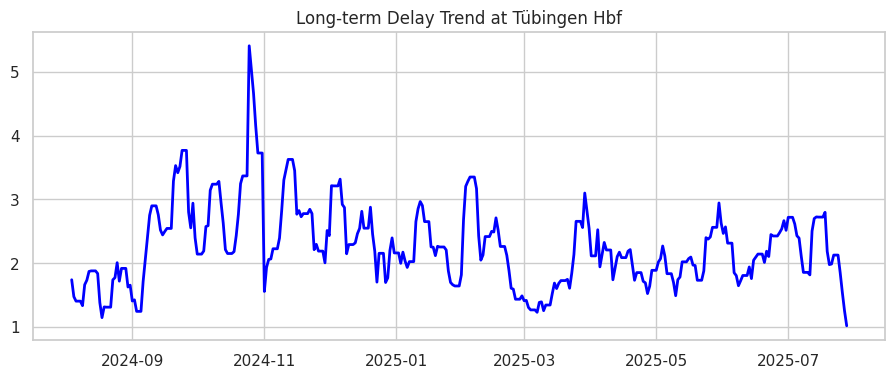

In [ ]:
daily_series = df.set_index('time')['delay_in_min'].resample('D').mean().fillna(0)
decomposition = seasonal_decompose(daily_series, model='additive', period=7)

plt.figure(figsize=(11, 4))
plt.plot(decomposition.trend, color='blue', linewidth=2)
plt.title('Long-term Delay Trend at Tübingen Hbf')
plt.show()

The trend suggests that delay levels vary over the year, with higher averages during autumn and early winter, followed by lower levels in spring and summer. This pattern is more indicative of seasonal effects than long-term improvement.

**B. Weekly Seasonality Patterns**

The seasonal component captures repeating weekly patterns in train delay by isolating systematic weekly effects from long-term trends and random flutuations.

* **Reference period**: September is selected as a reference period as it falls outside majos holiday periods and reflects more typical operating conditions.

* **Interpretation of values**: Negative values indicates days with lower-than-average delays, while positive values reflect systematic increases.


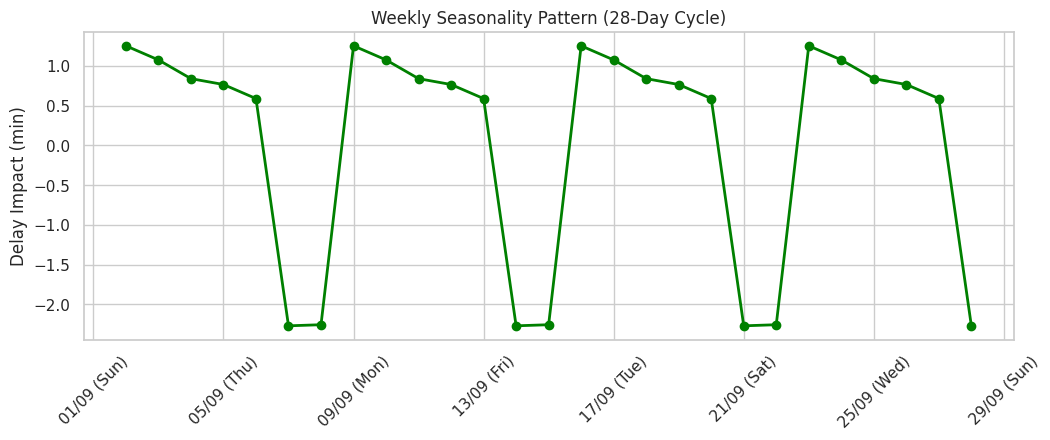

In [ ]:
seasonal_slice = decomposition.seasonal.iloc[32:59]

plt.figure(figsize=(12, 4))
plt.plot(seasonal_slice, color='green', marker='o', linewidth=2)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m (%a)'))
plt.xticks(rotation=45)
plt.title('Weekly Seasonality Pattern (28-Day Cycle)')
plt.ylabel('Delay Impact (min)')
plt.show()

The resulting pattern shows higher delays at the beginning of the week, especially on Mondays, followed by a decline toward Friday and a clear reduction over the weekend.


**C. Delays by Destination**

Finally, we analyze which destinations are most affected by delays. This provides practical insights for passengers traveling from Tübingen to other regional hubs.

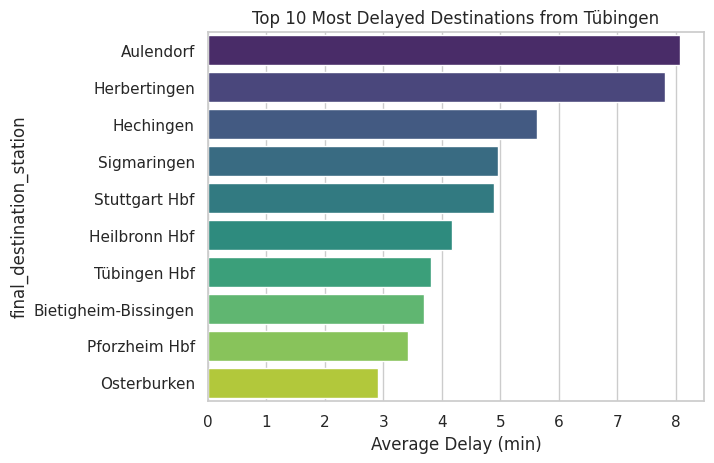

In [ ]:
top_destinations = df.groupby('final_destination_station')['delay_in_min'].mean().sort_values(ascending=False).head(10)

sns.barplot(x=top_destinations.values, y=top_destinations.index, hue=top_destinations.index, palette='viridis', legend=False)
plt.title('Top 10 Most Delayed Destinations from Tübingen')
plt.xlabel('Average Delay (min)')
plt.show()

The results show clear differences across destinations. Several regional routes experience higher average delays than major hubs, indicating that reliability challenges are not evenly distributed across the network.

This motivates a spatial analysis in the following subsection, where geographical patterns are examined more directly.

### 4.5. Geographical Analysis: Mapping Delay Patterns
A geographical visualization is used to **map average delays by destination**, supporting an intuitive understanding of how delays propagate spatially from Tübingen Hbf.

This spatial perspective helps reveal **directional patterns and regional bottlenecks** that are not visible in aggregate statistics.

It is important to note:

* many smaller towns function primarily as intermediate stops rather than final destinations. As a result, delays on short regional routes may be underrepresented at the city level and should be **interpreted mainly through regional and directional patterns**.

* In this map, Tübingen Hbf is treated as an operational hub rather than a destination. While some services return to Tübingen due to short loops or operational adjustments, these cases are excluded to focus on how delays propagate outward across the network.



In [ ]:
locations = {'Tübingen Hbf': [48.516, 9.057],'Aulendorf': [47.954, 9.638],'Herbertingen': [48.061, 9.439],'Hechingen': [48.358, 8.961],'Sigmaringen': [48.091, 9.215],'Stuttgart Hbf': [48.784, 9.181],'Heilbronn Hbf': [49.142, 9.220],'Albstadt-Ebingen': [48.217, 9.031],
    'Metzingen(Württ)': [48.537, 9.284],'Rottenburg(Neckar)': [48.477, 8.934],'Herrenberg': [48.597, 8.868],'Reutlingen Hbf': [48.493, 9.210],'Mössingen': [48.406, 9.052],'Balingen(Württ)': [48.273, 8.850]}
data = [('Aulendorf', 8.08, 'red'),('Herbertingen', 7.82, 'red'),('Hechingen', 5.62, 'orange'),('Sigmaringen', 4.97, 'orange'),
 ('Stuttgart Hbf', 4.90, 'orange'),('Heilbronn Hbf', 4.17, 'orange'),('Albstadt-Ebingen', 2.69, 'green'),('Metzingen(Württ)', 2.86, 'green'),('Rottenburg(Neckar)', 2.44, 'green'),('Herrenberg', 1.38, 'green'),('Reutlingen Hbf', 1.62, 'green'),('Mössingen', 0.78, 'green')]

fig = Figure(width=800, height=470)
m = Map(location=[48.37, 9.15], zoom_start=8.6, tiles='cartodbpositron')
fig.add_child(m)

# Central hub & Destinations
Marker(location=locations['Tübingen Hbf'], popup='Tübingen Hbf (Operational Hub)',icon=Icon(color='blue', icon='info-sign')).add_to(m)

for city, delay, color in data:
    if city in locations:
        CircleMarker(location=locations[city],radius=delay * 1.2, popup=f'{city}: {delay:.1f} min',color=color,fill=True,fill_opacity=0.6).add_to(m)
        PolyLine([locations['Tübingen Hbf'], locations[city]], color='gray',weight=1,opacity=0.3).add_to(m)
fig


The visualization shows that higher **average delays concentrate on southern and southeastern routes**, while connections to major hubs such as Stuttgart Hbf display comparatively lower average delays. This suggests that reliability issues are more strongly associated with regional infrastructure constraints than with higher traffic volumes alone.


### 4.6. Train Category Impact: Regional vs. Express Services

The train category plays an important role in understanding delay behavior, as **services differ in operational design** such as stop frequency, average speed, and route length.

To assess this effect, trains are grouped into:

* **Regional Services** (RB, MEX, SWE): characterized by frequent stops and primarily local or short-distance coverage.

* **Express Services** (RE, IRE, IC): operating with fewer stops and higher average speeds.

Although **IC trains** are officially classified as long-distance services, they are included in the express group for analytical purposes due to their operational similarity to faster regional express services.

In [ ]:
express_trains = ['RE', 'IRE', 'IC']
regional_trains = ['RB', 'MEX', 'SWE']

df['service_group'] = df['train_type'].apply(lambda x: 'Express' if x in express_trains else 'Regional')
print(df.groupby('service_group')['delay_in_min'].describe().round(2))

                 count  mean   std  min  25%  50%  75%    max
service_group                                                
Express         3332.0  5.68  8.43  0.0  1.0  4.0  7.0  152.0
Regional       21428.0  2.85  6.54  0.0  0.0  1.0  3.0  331.0


Express services show **higher average** delays than regional trains (5.68 vs. 2.85 minutes). This pattern may reflect the longer routes covered by express services and greater exposure to network-wide disruptions.

Regional servicies, while generally more punctual, exhibit **more extreme delay outliers**, indicating vulnerability to occasional high-impact incidents.

Overall, these differences suggest that delay behavior is influenced not only by traffic volume, but also by service structure.


### 4.7. Section Insights

By combining statistical summaries, time series decomposition, and geographical visualization, three consistent patterns emerge:

* **Temporal concentration of disruptions**: Delays and cancellations peak at the beginning of the week, with Mondays standing out as the most fragile operational day. This suggests reduced resilience at the start of the operational cycle.

* **Service-type differences**: Delay behavior differs between regional and express services, indicating that service structure and operational design influence reliability beyond traffic volume alone.

* **Directional and regional bottlenecks**: While public attention often focuses on northern routes affected by the Stuttgart 21 construction, the data indicates that **southbound routes** toward the Swabian Alps experience significantly **higher average delays**. This suggests that regional infrastructure outside major hubs may be more prone to instability than high-traffic corridors.

These descriptive findings motivate the formal hypothesis testing conducted in the following section, where their statistical significance is assessed.

## 5. Hypothesis Testing
In this section, we apply statistical methods to determine if the patterns observed during our exploration are statistically significant. By testing these assumptions, we aim to preserve the full operational reality of the network.

### 5.1. Hypothesis 1: The "Monday Effect" (Independent T-test)

* **Null Hypothesis ($H_0$)**: There is no significant difference between the average delay on Mondays and the average delay on all other days.
* **Alternative Hypothesis ($H_1$)**: The average delay on Mondays is significantly higher than on other days.

In [ ]:
# Preparing the two groups
monday_delays = df[df['time'].dt.dayofweek == 0]['delay_in_min']
other_days_delays = df[df['time'].dt.dayofweek != 0]['delay_in_min']

# Performing the Independent T-Test
t_stat, p_value = stats.ttest_ind(monday_delays, other_days_delays, equal_var=False)
print(f"Monday Mean Delay: {monday_delays.mean():.2f} min")
print(f"Other Days Mean Delay: {other_days_delays.mean():.2f} min")
print(f"\nT-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4e}")

# Decision
if p_value < 0.05:
    print("\nResult: Reject the Null Hypothesis (Statistically Significant)")
    print("The 'Monday Effect' is real: Mondays are significantly more delayed.")
else:
    print("\nResult: Fail to reject the Null Hypothesis (Not Statistically Significant)")

Monday Mean Delay: 3.59 min
Other Days Mean Delay: 3.14 min

T-statistic: 3.2677
P-value: 1.0901e-03

Result: Reject the Null Hypothesis (Statistically Significant)
The 'Monday Effect' is real: Mondays are significantly more delayed.


**Interpretation:**
The independent t-test indicates that the average delay on Mondays is significantly higher than on other weekdays, with a p-value of approximately 0.001. Although the absolute difference is moderate, this result statistically confirms the temporal fragility observed during the exploratory analysis.

### 5.2. Hypothesis 2: Train Category Impact (Independent T-test)


Here we investigate if regional trains experience different delay patterns compared to express services.

* **Null Hypothesis ($H_0$)**: There is no significant difference in average delay between Regional and Express categories.
* **Alternative Hypothesis ($H_1$)**: There is a significant difference in average delay between these categories.

In [ ]:
# Grouping train types
regional_types = ['RB', 'MEX','SWE']
express_types = ['RE', 'IRE', 'IC']
regional_delays = df[df['train_type'].isin(regional_types)]['delay_in_min']
express_delays = df[df['train_type'].isin(express_types)]['delay_in_min']

# Performing the T-Test
t_stat_cat, p_value_cat = stats.ttest_ind(regional_delays, express_delays, equal_var=False)
print(f"Regional Mean Delay: {regional_delays.mean():.2f} min")
print(f"Express Mean Delay: {express_delays.mean():.2f} min")
print(f"\nT-statistic: {t_stat_cat:.4f}")
print(f"P-value: {p_value_cat:.4e}")

# Decision
if p_value_cat < 0.05:
    print("\nResult: Reject the Null Hypothesis (Statistically Significant)")
    print("The train category significantly impacts the expected delay.")
else:
    print("\nResult: Fail to reject the Null Hypothesis (Not Statistically Significant)")
    print("There is no significant evidence that train category affects delay averages.")

Regional Mean Delay: 2.85 min
Express Mean Delay: 5.68 min

T-statistic: -18.5511
P-value: 9.5013e-74

Result: Reject the Null Hypothesis (Statistically Significant)
The train category significantly impacts the expected delay.


**Interpretation:** The test shows a strong difference between service categories. Express trains exhibit a  higher average delay compared to regional services.

The extremely low p-value confirms that train category is a major structural factor influencing delay behavior across the network and the  T-statistic (-18.55) reinforces the structural importance of train category in explaining delay differences.

### 5.3. Statistical Summary

The hypothesis testing phase reinforces two key insights from the exploratory analysis and guide the subsequent modeling strategy:

* **Systemic Monday Fragility**: Mondays show a statistically significant increase in average delays compared to other weekdays. While the absolute difference is moderate, this result confirms the temporal vulnerability observed during exploratory analysis.

* **Service Category Impact**: The difference between Regional and Express services represents the strongest statistical result in this section. The magnitude of this gap confirms train category as a fundamental structural driver of delay behavior at a global level.


## 6. Modeling Strategy and Data Scope

Before proceeding to feature engineering and model training, this section defines the overall modeling strategy and clarifies how the dataset supports multiple machine learning objectives.

At this stage, the dataset has already been inspected and validated and no additional data filtering is applied.


 ### 6.1. Hybrid Modeling Approach

To capture both everyday variability and systemic risk, this project adopts a hybrid modeling approach, addressing two complementary predictive tasks, with distinct operational goals:

**Regression (Predicting Delay Duration)**: For the regression task, extreme delay values are excluded from the training data to prevent them from disproportionately influencing minute-level predictions. This allows the model to focus on estimating expected delay durations under typical operating conditions, which better reflects the standard passenger experience.

**Classification (Assessing Delay Risk)**: The classification task explicitly incorporates extreme events by labeling delays above a 5-minute threshold as Critical Delays. This allows the model to learn patterns associated with network vulnerability and high-impact disruptions, which are often difficult to identify when relying only on average delay metrics.


### 6.2. Modeling Dataset Definition and Scope

All feature engineering steps in the next section operate on a unified dataset (`df_model`), which includes:

* all recorded services,

* all observed delay values,

* no filtering beyond what is explicitly model-specific.

Model-specific data handling decisions (such as outlier exclusion for regression tasks) are applied after feature engineering, ensuring consistency across both regression and classification pipelines.


## 7. Feature Engineering

In this section, we transform our modeling dataset (`df_model`), defined in the previous section, into structured features suitable for Machine Learning.

### 7.1. Temporal Features Extraction
Time-series data is periodic. By extracting specific components from the `time` column, we allow the model to learn temporal patterns.

The following temporal features are created:

*	`month`: captures broader seasonal influences such as weather conditions and holiday periods.

*	`day_of_week`: allows the model to learn weekday-specific effects. This feature helps distinguish early-week operational instability from the smoother patterns often observed toward the end of the week.

*	`hour`: captures the daily operational cycle of the station.

*	`is_rush_hour`: flags morning (07–09) and evening (16–18) peak periods, acting as an indicator of higher system load and increased vulnerability to cascading delays, where a single delay is more likely to propagate and affect subsequent services.







In [ ]:
df_model = df.copy()

# Extracting day of the week, hour, and month
df_model['hour'] = df_model['time'].dt.hour
df_model['day_of_week'] = df_model['time'].dt.dayofweek
df_model['month'] = df_model['time'].dt.month

# Creating a "Rush Hour" feature
df_model['is_rush_hour'] = df_model['hour'].isin([7, 8, 9, 16, 17, 18]).astype(int)

df_model[['time','hour', 'is_rush_hour', 'day_of_week', 'month']].head()

,time,hour,is_rush_hour,day_of_week,month
0,2024-08-01 08:05:00,8,1,3,8
1,2024-08-01 08:06:00,8,1,3,8
2,2024-08-01 08:13:00,8,1,3,8
3,2024-08-01 08:17:00,8,1,3,8
4,2024-08-01 08:31:00,8,1,3,8


### 7.2. Categorical Feature Encoding
The features `train_type` and `final_destination_station` are categorical and must be converted into numerical representations for Machine Learning models.

Two encoding strategies are applied:


* **One-Hot Encoding for `train_type`**: Train categories are encoded as binary variables to avoid introducing artificial ordinal relationships. This prevents implying, for example, that an “IRE” is mathematically greater than an “RB”.

* **Label Encoding for `final_destination_station`**: Since there are many destinations, applying One-Hot Encoding would create too many columns. Label encoding is used instead. Although this encoding introduces an arbitrary numerical order, tree-based models such as Random Forests are insensitive to ordinal relationships, making this approach suitable for the current context.

In [ ]:
# One-Hot Encoding for `train_type`
df_model = pd.get_dummies(df_model,
    columns=['train_type'],prefix='type',drop_first=False)

# Label Encoding for `final_destination_station`
le = LabelEncoder()
df_model['destination_id'] = le.fit_transform(df_model['final_destination_station'])

print("Categorical features encoded:")
print(list(df_model.filter(regex='type_|destination_id').columns))

Categorical features encoded:
['type_IC', 'type_IRE', 'type_MEX', 'type_RB', 'type_RE', 'type_SWE', 'destination_id']


### 7.3. Feature Validation Before Modeling

Before training the models, we perform a correlation check using `df_model` to verify whether the engineered temporal features show linear relationships with the target variable (`delay_in_min`).




In [ ]:
# Selecting numerical features for correlation check
corr_features = ['delay_in_min','hour', 'day_of_week','month','is_rush_hour']
corr_matrix = df_model[corr_features].corr()
# Correlation with target
print(corr_matrix['delay_in_min'].sort_values(ascending=False))


delay_in_min    1.000000
is_rush_hour    0.076613
month           0.045095
day_of_week    -0.032505
hour           -0.069462
Name: delay_in_min, dtype: float64


As expected, the temporal features show weak linear correlations with delay duration, reinforcing the choice of a non-linear model (Random Forest) and helping to explain why predicting exact delay minutes is difficult, motivating the later shift to risk-based classification.

###7.4. Modeling Dataset Overview
After feature engineering, the resulting dataset contains all original observations augmented with engineered temporal and categorical features.
This dataset serves as the unified input for both regression and classification models in the subsequent sections.


In [ ]:
print(f"Dataset size for modeling: {df_model.shape}")
df_model.head()


Dataset size for modeling: (24760, 28)


,station_name,xml_station_name,eva,train_name,final_destination_station,delay_in_min,time,is_canceled,train_line_ride_id,train_line_station_num,...,day_of_week,month,is_rush_hour,type_IC,type_IRE,type_MEX,type_RB,type_RE,type_SWE,destination_id
0,Tübingen Hbf,Tübingen Hbf,8000141,RB 74,Tübingen Hbf,4,2024-08-01 08:05:00,False,NaN,8,...,3,8,1,False,False,False,True,False,False,23
1,Tübingen Hbf,Tübingen Hbf,8000141,RB 6,Rottenburg(Neckar),0,2024-08-01 08:06:00,False,NaN,1,...,3,8,1,False,False,False,True,False,False,20
2,Tübingen Hbf,Tübingen Hbf,8000141,RB 63,Tübingen Hbf,0,2024-08-01 08:13:00,False,NaN,8,...,3,8,1,False,False,False,True,False,False,23
3,Tübingen Hbf,Tübingen Hbf,8000141,RB 63,Herrenberg,0,2024-08-01 08:17:00,False,4.682770e+18,1,...,3,8,1,False,False,False,True,False,False,11
4,Tübingen Hbf,Tübingen Hbf,8000141,SWE RB66,Tübingen Hbf,3,2024-08-01 08:31:00,False,NaN,17,...,3,8,1,False,False,False,False,False,True,23


## 8. Regression Modeling

In this section, we begin the modeling phase by predicting the exact number of minutes a train will be delayed. `delay in min` is a continuous target, making it a Regression problem.

### 8.1. Data Splitting
We split the data into a **Training Set (80%)** and a **Test Set (20%)** to evaluate the model on unseen data.

The selected features were chosen based on earlier exploratory analysis and hypothesis testing, focusing on temporal patterns and service characteristics that showed measurable impact on delays.

In [ ]:
# Selecting specific engineered features
features = ['day_of_week', 'hour', 'month', 'is_rush_hour', 'destination_id', 'type_IC', 'type_IRE', 'type_MEX', 'type_RB', 'type_RE', 'type_SWE']
X = df_model[features]
y = df_model['delay_in_min']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 8.2. Model Selection: Random Forest Regressor
We selected the Random Forest Regressor for its ability to capture non-linear relationships between features like `hour`, `is_rush_hour` and train categories (like `type_IC`) without requiring extensive feature scaling.

In [ ]:
# Initializing and training the model and making predictions
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)
y_pred = model_rf.predict(X_test)

### 8.3. Evaluation Metrics & Results
To assess the model's accuracy, we use the **Mean Absolute Error (MAE**) and the **R² Score**. MAE is used because it is easy to interpret in minutes, while R² helps assess how much variance in delays is explained by the model.

In [ ]:
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae:.2f} minutes")
print(f"R2 Score: {r2:.4f}")

Mean Absolute Error: 3.20 minutes
R2 Score: -0.0426


**Analysis of Results:**

* **The Error Margin**: A MAE of 3.20 minutes suggests the model performs reasonably well for typical, low-delay situations.

* **The R² Paradox**: The negative R² score indicates that extreme delay events are highly unpredictable and not well explained by time-based features alone.

* **Limitation of Minute-Level Prediction**: While short delays are typically influenced by structural factors such as seasonality, service type, and time of day, delays caused by external operational events (e.g., weather events, infrastructure work, technical failures) are not explicitly captured in the dataset. As a result, predicting exact delay minutes becomes unstable for rare but high-impact events.

* **Strategic Pivot**: Since predicting exact minutes is unstable due to the chaotic nature of disruptions, we will now shift to a **classification approach** to predict high-risk scenarios (> 5 minutes).

## 9. Post-Regression Analysis: Rush Hour and Passenger Perception
While the regression model achieved a low Mean Absolute Error, passenger frustration remains high. This apparent contradiction suggests that **average delay metrics alone do not fully reflect how delays are experienced by passengers**.

To explore this further, we conduct a post-regression analysis focused on rush hour periods, examining when delays occur and how severe they are during peak travel times.




### 9.1. Rush Hour vs. Off-Peak Hour
As shown earlier, while the overall mean delay is 3.23 minutes, trains that are actually delayed experience an average delay of 4.78 minutes. This difference helps explain why passenger frustration often exceeds what aggregate metrics suggest, especially for daily commuters, usually traveling during peak hours.

To test if "Rush Hour" (7-9 AM / 4-6 PM) increases delays, we segmented the data and compared peak with off-peak hours and we compare these periods in two ways:

* **Overall Mean Delay**: including on-time and delay services

* **Conditional Mean Delay**: considers only trains that were actually delayed (`delay_in_min` > 0)


In [ ]:
# Overall Mean Delay (on-time and delay services)
rush_mean = df_model[df_model['is_rush_hour']==1]['delay_in_min'].mean()
offpeak_mean = df_model[df_model['is_rush_hour']==0]['delay_in_min'].mean()
print(f"Rush Hour Overall Mean Delay: {rush_mean:.2f} min")
print(f"Off-Peak Overall Mean Delay: {offpeak_mean:.2f} min")

Rush Hour Overall Mean Delay: 3.83 min
Off-Peak Overall Mean Delay: 2.77 min


In [ ]:
# Conditional Mean Delay (delayed services only)
rush_conditional = df_model[(df_model['is_rush_hour'] == 1) & (df_model['delay_in_min'] > 0)]['delay_in_min'].mean()
offpeak_conditional = df_model[(df_model['is_rush_hour'] == 0) & (df_model['delay_in_min'] > 0)]['delay_in_min'].mean()
print(f"Rush Hour Mean Delay (delayed only): {rush_conditional:.2f} min")
print(f"Off-Peak Mean Delay (delayed only): {offpeak_conditional:.2f} min")


Rush Hour Mean Delay (delayed only): 5.20 min
Off-Peak Mean Delay (delayed only): 4.39 min


**Interpretation**: Delays are higher during rush hours in general, especially when a train is already delayed. While off-peak delays average 4.39 minutes, rush-hour delays increase to 5.20 minutes, making disruptions more noticeable for daily commuters even when overall averages remain moderate.

### 9.2. Express vs. Regional Services in Rush Hours
To understand whether train types are affected equally during peak hours, we compared express and regional trains during peak and off-peak periods.


In [ ]:
# Express (RE, IRE, IC)
express_rush = df_model[(df_model['is_rush_hour'] == 1) & ((df_model['type_RE'] == 1) | (
    df_model['type_IRE'] == 1) | (df_model['type_IC'] == 1))]['delay_in_min'].mean()
express_off = df_model[(df_model['is_rush_hour'] == 0) & ((df_model['type_RE'] == 1) | (
    df_model['type_IRE'] == 1) | (df_model['type_IC'] == 1))]['delay_in_min'].mean()
print(f"Express Rush Hour Delay: {express_rush:.2f} min")
print(f"Express Off-Peak Delay: {express_off:.2f} min")


Express Rush Hour Delay: 5.98 min
Express Off-Peak Delay: 5.42 min


In [ ]:
# Regional (RB, MEX, SWE)
regional_rush = df_model[(df_model['is_rush_hour'] == 1) & ((df_model['type_RB'] == 1) | (
    df_model['type_MEX'] == 1) | (df_model['type_SWE'] == 1))]['delay_in_min'].mean()
regional_off = df_model[(df_model['is_rush_hour'] == 0) & ((df_model['type_RB'] == 1) | (
    df_model['type_MEX'] == 1) | (df_model['type_SWE'] == 1))]['delay_in_min'].mean()
print(f"Regional Rush Hour Delay: {regional_rush:.2f} min")
print(f"Regional Off-Peak Delay: {regional_off:.2f} min")

Regional Rush Hour Delay: 3.46 min
Regional Off-Peak Delay: 2.38 min


* **Express services** show higher average delays both during rush hours and off-peak periods, suggesting greater exposure to network congestion and long-distance disruption effects.

* **Regional services**, while less delayed on average, experience a sharper increase during rush hours, contributing differently to passenger perception of reliability.


### 9.3. Key Insight: The Passenger Perception Gap
This analysis highlights the difference between operational performance metrics and passenger experience.

*  Overall averages are influenced by
a high share of punctual trains.
*  Rush hours increase the severity of delays.
*  Some services are operationally prioritized during peak periods.

Average delay values often underestimate how disruptive delays feel in practice. This motivates the transition from regression toward a **classification model**, focused on identifying critical delay situations rather than predicting exact delay minutes.


## 10. Classification Modeling: Predicting Critical Delays
Given the limited explanatory power of linear temporal effects and the gap identified between average delays and passenger experience,instead of predicting the exact delay duration, we now focus on a binary classification task: predicting whether a train will suffer a **critical delay (> 5 minutes)**.

### 10.1. Defining the Target: The 5-Minute Threshold
We created a new target variable, `is_critical_delay`. In the railway context, 5 minutes is a commonly used  threshold where most passengers begin to miss connections.

In [ ]:
# 1 = Critical Delay (> 5 min), 0 = On Time/Minor Delay (<= 5 min)
df_model['is_critical_delay'] = (df_model['delay_in_min'] > 5).astype(int)

### 10.2. Model Training: Random Forest Classifier
We used the **Random Forest Classifier** to handle the non-linear relationships we identified earlier.

In [ ]:
# Updating features and target
y_class = df_model['is_critical_delay']
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.2, random_state=42)

# Training the Classifier and making predictions
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

### 10.3. Evaluation: Accuracy vs. Precision/Recall
In train delays, **Recall** is critical: we want to minimize "False Negatives" (predicting a train is on time when it is actually late). We  check the recall and accuracy using a confusion matrix and a classification report.

In [ ]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Confusion Matrix:
[[3827  301]
 [ 600  224]]


In [ ]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.93      0.89      4128
           1       0.43      0.27      0.33       824

    accuracy                           0.82      4952
   macro avg       0.65      0.60      0.61      4952
weighted avg       0.79      0.82      0.80      4952



**Insights:**

* **Accuracy (82%)**: The classification model provides a more stable and actionable decision framework than minute-level regression.

* **Precision (Class 0: 0.86)**: When the model predicts a train will be on time, it is correct in most cases, making it a reliable tool for building passenger trust.

* **Recall (Class 1: 0.27)**: Critical delays remain difficult to detect, as they are often driven by random external events (e.g., weather or technical failures) not fully captured in the dataset. This reflects a data limitation rather than a modeling failure.


## 11. Classification Analysis: Why do Critical Delays Happen?
By shifting to a classification task, we achieve a more robust performance (82% accuracy) compared to regression. The feature importance below shows what drives a train to cross the "critical delay" threshold of 5 minutes.

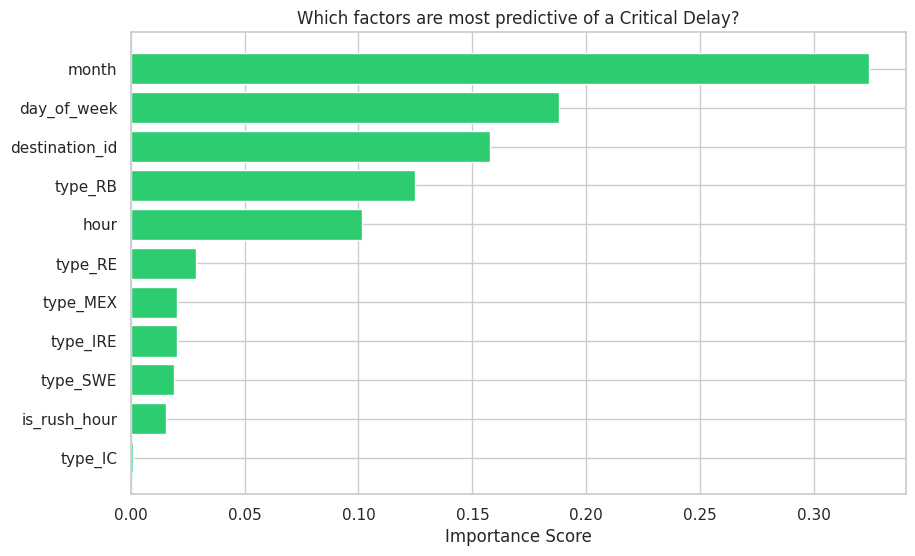

In [ ]:
# Getting feature importance from the Classifier
importances = clf.feature_importances_
feature_importance_df = pd.DataFrame({'feature': features, 'importance': importances}).sort_values(by='importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'], color='#2ecc71')
plt.xlabel('Importance Score')
plt.title('Which factors are most predictive of a Critical Delay?')
plt.gca().invert_yaxis()
plt.show()

**Technical Insights:**

* **Seasonal Driver:** The dominance of the `month` variable confirms that delays are tied to seasonal cycles (snow, heat, or maintenance) rather than daily hourly fluctuations.

* **Monday Effect:** `day_of_week` ranking second validates our Hypothesis Test: Mondays are one of the most reliable predictors of service disruption.

* **Spatial Constraints:**
`destination_id` confirms that specific routes face consistent infrastructure bottlenecks.

* **Train Type Effects**: While individual train type variables appear lower in isolation, their combined importance shows that service category (express vs. regional) plays a meaningful role in the likelihood of critical delays.

## 12. Conclusion & Final Insights

### 12.1. Project Summary

What started as a personal observation during my time as a commuter in the Tübingen region has been transformed into a comprehensive data-driven analysis. By examining one full year of railway operations at Tübingen Hbf, this project bridges the gap between passenger perception and statistical reality, translating everyday frustration into measurable operational insights.

### 12.2. Key Findings

* **The "Monday Effect"**: Hypothesis testing confirmed, with statistical significance (𝑝 < 0.05), that Mondays experience higher average delays. This validates a widely shared commuter perception and highlights the start of the week as a structurally vulnerable period.

* **The Perception Gap (Rush Hour)**: Delays are significantly higher during peak hours (3.83 min vs. 2.77 min) across all services, explaining why daily commuters perceive the system as unreliable, even if the "average" delay seems low.

* **The Southern Bottleneck**: Contrary to the common assumption that disruptions concentrate around Stuttgart, spatial analysis revealed that routes heading **south from Tübingen**, toward the Swabian Alb region, face more consistent infrastructure constraints.

* **Seasonal vs. Hourly Drivers**:  Modeling results show that **month** and **day of the week** are more predictive of delays than the specific hour of departure, indicating that weekly rhythms and seasonal factors (weather, maintenance cycles) impact performance more than daily rush-hour timing alone.

* **Service-Type Differences**: Express services exhibit higher average delays than regional trains both during rush hours and off-peak periods. This suggests that long-distance services are more exposed to network-wide disruptions, while regional services, although generally more punctual, remain vulnerable to peak-hour congestion.


* **Predictability Threshold**: Predicting exact delay minutes proved unstable due to unobserved operational factors and rare high-impact disruptions, reflected in a negative R² **(the R² paradox)**. Reframing the task as a classification problem showed more robust results: the model predicts critical delays (>5 minutes) with 82% accuracy and provides a reliable “on-time” signal with 86% precision.



### 12.3. Strategic Recommendations
* **For Passengers**: The high precision of on-time predictions (0.86) suggests that a real-time “Punctuality Alert” system could meaningfully support travel planning, especially for long-distance connections where reliability is most critical.

* **For Infrastructure Planning**: Identified southern bottlenecks and the strong role of seasonality highlight the need for targeted infrastructure investments, including localized track improvements and more resilient winter maintenance strategies.


### 12.4. Final Reflection
This project demonstrates that while railway systems will always be exposed to unpredictable operational uncertainty, Data Science provides powerful tools to identify structural vulnerabilities. By transforming commuter frustration into a robust **predictive framework with 82% accuracy**, this analysis shows how data-driven insights can improve expectations, support decision-making, and enhance trust in urban mobility systems.


## 13. Next Steps
To further enhance the predictive power of this analysis, the following steps are proposed:

1. **Weather Data Integration**: Incorporate historical weather data (snowfall, heavy rain, and temperature) from the Deutscher Wetterdienst (DWD) to explicitly quantify the impact of adverse conditions on delays.
This would help validate seasonal patterns, assess whether weather amplifies cascading effects, and refine the understanding of temporal vulnerabilities.


2. **Infrastructure & Construction Logs**: Merge the dataset with planned maintenance schedules (**Baustellen**) to distinguish between expected, structural delays and truly unexpected disruptions.

3. **Real-Time API Deployment**: Develop a lightweight API (e.g.,FastAPI) to provide live delay risk predictions for passengers departing from Tübingen Hbf.

4. **Deep Learning Approach**: Experiment with Recurrent Neural Networks (RNNs) or LSTMs to capture time-series dependencies and longer-term operational patterns that traditional models might miss.